In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from utils.get_sequences import get_sequences
from utils.split_data import split_data
from sklearn.preprocessing import StandardScaler
from data_files.data_module import EnergyChickenDataModule
from model_files.model import LSTM
from model_files.trainer import Trainer
from torch.optim import Adam, SGD, Adadelta, AdamW, Adagrad
import matplotlib.pyplot as plt
import json

import warnings
warnings.filterwarnings("ignore")

In [7]:
RANDOM_SEED = 42
SPLITER_COUNT = 0.8
WINDOW_LENGHTS = [12, 24, 24*7, 24*7*2, 24*7*4, 24*7*4*3]
BATCH_SIZE = 32
MAX_COUNT_DECREASING = 10
LEARNING_RATE = 0.001
N_EPOCHS = 100
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
from datetime import datetime

df = pd.read_csv('data_files/processed.csv')
df.drop(columns=df.columns[0], inplace=True)
scaler = StandardScaler()
data = torch.FloatTensor(scaler.fit_transform(df.iloc[:, 0].to_numpy().reshape((-1, 1)))).to(DEVICE)[:]

current_date = datetime.now().strftime('%d.%m.%Y')
comparison_logs = {}


In [9]:
for win_len in WINDOW_LENGHTS:
    sequences = get_sequences(data, win_len)
    train, test = split_data(sequences, SPLITER_COUNT)

    print(f'Learning with {win_len} hours window')

    data_module = EnergyChickenDataModule(train, test)
    data_module.setup()
    model = LSTM(device=DEVICE)
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.MSELoss()

    trainer = Trainer(model=model, 
                    optimizer=optimizer, 
                    loss_function=criterion,
                    n_epochs=N_EPOCHS,
                    device=DEVICE,
                    max_count_decreasing=MAX_COUNT_DECREASING)

    train_dataloader = data_module.train_dataloader()
    test_dataloader = data_module.test_dataloader()
    trainer.upload_data(train_dataloader, test_dataloader)

    trainer.fit()
    
    comparison_logs[win_len] = trainer.logs
    with open(f'comparisons/compatison_win_len_results_{current_date}.json', 'w') as file:
        json.dump(comparison_logs, file, ensure_ascii=False, indent=4)

Learning with 12 hours window
epoch 1 train_loss 0.163449 test_loss 0.145869 time 31.360737
epoch 2 train_loss 0.09824 test_loss 0.11957 time 26.096015
epoch 3 train_loss 0.082527 test_loss 0.126641 time 26.97223
epoch 4 train_loss 0.079759 test_loss 0.090419 time 35.793805
epoch 5 train_loss 0.068163 test_loss 0.07006 time 37.6588
epoch 6 train_loss 0.06271 test_loss 0.065611 time 37.46313
epoch 7 train_loss 0.057522 test_loss 0.064318 time 37.124304
epoch 8 train_loss 0.053835 test_loss 0.064027 time 37.506387
epoch 9 train_loss 0.048732 test_loss 0.063359 time 38.077179
epoch 10 train_loss 0.047339 test_loss 0.060101 time 38.044598
epoch 11 train_loss 0.0458 test_loss 0.058518 time 38.744748
epoch 12 train_loss 0.044616 test_loss 0.052725 time 38.83915
epoch 13 train_loss 0.041286 test_loss 0.05373 time 37.426366
epoch 14 train_loss 0.037188 test_loss 0.050095 time 37.5168
epoch 15 train_loss 0.044409 test_loss 0.052169 time 38.336422
epoch 16 train_loss 0.038999 test_loss 0.047708 

In [10]:
with open(f'comparisons/compatison_win_len_results_{current_date}.json', 'r') as file:
    comparison_logs = json.load(file)

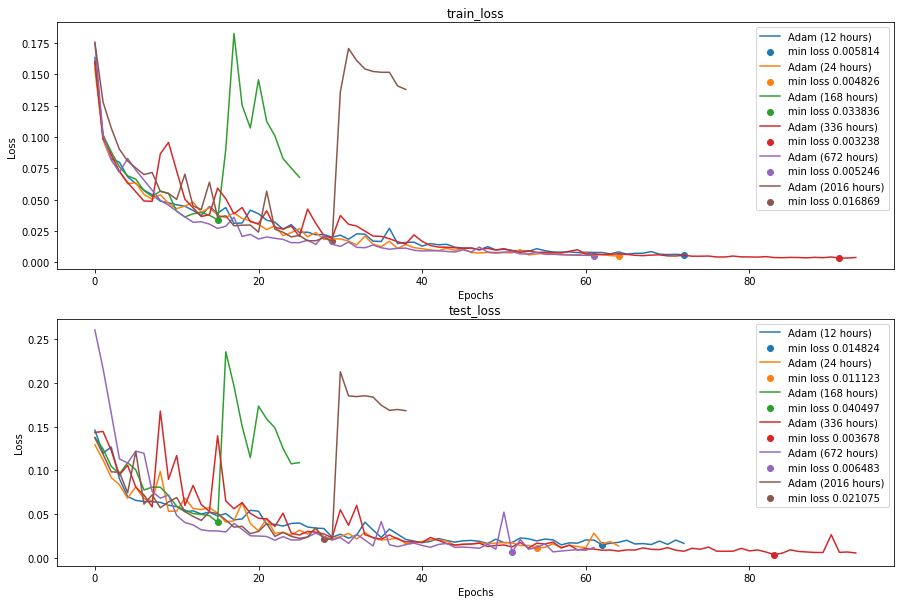

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))

for index, col in enumerate(['train_loss', 'test_loss']):
    for win_len, data in comparison_logs.items():
        loss = data[col]

        min_loss = min(loss)
        min_loss_epoch = loss.index(min_loss)
        # print(f'{min_loss}  {min_loss_epoch}')


        ax[index].plot(loss, label=f'Adam ({win_len} hours)')
        ax[index].scatter([min_loss_epoch], [min_loss], label=f'min loss {min_loss}')
        ax[index].set_title(f'{col}')
        ax[index].set_xlabel('Epochs')
        ax[index].set_ylabel('Loss')
        ax[index].legend()


<BarContainer object of 6 artists>

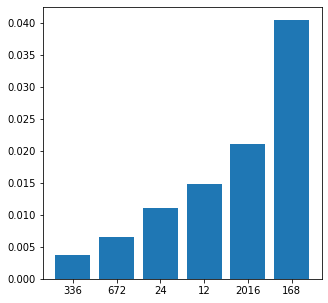

In [33]:
test_losses = {
    optimizer: float(np.min(data['test_loss'])) for optimizer, data in comparison_logs.items()
}
test_losses = {k:v for k, v in sorted(test_losses.items(), key=lambda item: item[1])}
plt.figure(figsize=(5, 5))
plt.bar(test_losses.keys(), test_losses.values())

In [38]:
round((1 - test_losses['336'] ** 0.5) * 100)

94

<BarContainer object of 6 artists>

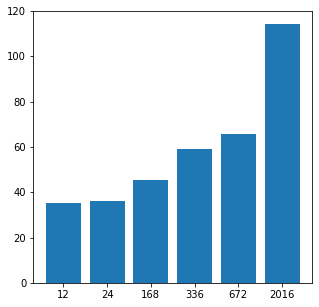

In [34]:
mean_time = {
    optimizer: float(np.mean(data['time'])) for optimizer, data in comparison_logs.items()
}
mean_time = {k:v for k, v in sorted(mean_time.items(), key=lambda item: item[1])}
plt.figure(figsize=(5, 5))
plt.bar(mean_time.keys(), mean_time.values())

In [43]:
round(mean_time['336'], 3)

59.115

<BarContainer object of 6 artists>

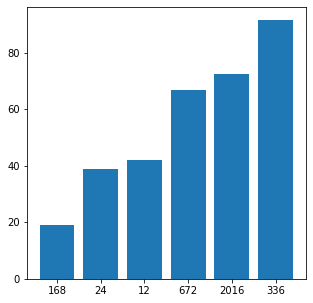

In [35]:
total_time = {
    optimizer: float(np.sum(data['time'])/60) for optimizer, data in comparison_logs.items()
}
total_time = {k:v for k, v in sorted(total_time.items(), key=lambda item: item[1])}
plt.figure(figsize=(5, 5))
plt.bar(total_time.keys(), total_time.values())

In [41]:
round(total_time['336'] / 60, 2)

1.53

As you can see, a model with a window length value of 336 predicts the value most effectively (94%), but the total training time in this case is the largest (1.53 hours), when as the epoch time is the average among the rest (59 seconds). It is necessary to try to increase the number of training epochs and MAX_COUNT_DECREASING and see how the model behaves